<a href="https://colab.research.google.com/github/Rbca0/Data-Science/blob/main/UNIDADSEIS/Rebecca_project6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import graphviz as gv
import matplotlib.pyplot as plt
import seaborn as sns

data --> https://science.ebird.org/en/status-and-trends/species/comcra/range-map?week=1

https://docs.google.com/spreadsheets/d/1Hwx3pF0sV332Sajio4myMtDq_pkIyl0TTIIQAdUzrMg/edit?gid=716732058#gid=716732058

I am trying to ppredct the mean abundance of the Common Crane on every continent (except antarctica) using with eBird data detailing range, season (whether it's pre-, post-, or during breeding season), and other geographical data.

This is how I think the causal diagram works.

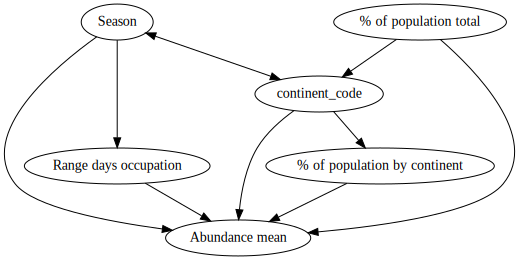

In [2]:
#single predictor causal diagram
dag_b = gv.Digraph(comment='birds_data') #b for birds

dag_b.node('A', 'Abundance mean')
dag_b.node('R','Range days occupation')
dag_b.node('P','% of population by continent')
dag_b.node('T','% of population total')
dag_b.node('C','continent_code')
dag_b.node('S','Season')

dag_b.edges(['CA', 'SA', 'PA', 'RA', 'TC', 'TA', 'CP', 'SR'])
dag_b.edge('S', 'C', dir='both')

dag_b

Here is my data, but it needs to be cleaned.

In [3]:
bird = pd.read_csv('https://raw.githubusercontent.com/Rbca0/Data-Science/refs/heads/main/UNIDADSEIS/comcra_regional_2023%20-%20comcra_regional_2023.csv')
bird

,https://science.ebird.org/en/status-and-trends/species/comcra/range-map?week=1,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,"estimated total pop: 545,000",Unnamed: 7,Unnamed: 8,how many you see ideally in 2 hours,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
0,prediction_year,region_type,region_code,region_name,continent_code,continent_name,season,start_date,end_date,abundance_mean,total_pop_percent,continent_pop_percent,range_occupied_percent,range_total_percent,range_days_occupation,max_week,max_week_percent_pop
1,2023,country,AFG,Afghanistan,AS,Asia,prebreeding_migration,2023-02-01,2023-06-07,0.2514071527,0.001031439455,0.001405546798,0.1289616387,0.002166196796,21,2023-04-05,0.002923433005
2,2023,country,ALB,Albania,EU,Europe,nonbreeding,2023-12-06,2023-01-25,0.2564122107,1.03E-04,5.53E-04,0.1094655207,0.001274532875,42,2023-12-27,1.24E-04
3,2023,country,ALB,Albania,EU,Europe,postbreeding_migration,2023-07-26,2023-11-29,0.07435682461,1.90E-05,3.94E-05,0.1128990575,5.07E-04,35,2023-11-22,9.15E-05
4,2023,country,ALB,Albania,EU,Europe,prebreeding_migration,2023-02-01,2023-06-07,0.054193186,4.88E-05,2.01E-04,0.1017386766,3.75E-04,56,2023-03-01,2.43E-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4101,2023,state,WLS-2132,Monmouthshire,EU,Europe,prebreeding_migration,2023-02-01,2023-06-07,2.72E-04,7.54E-09,3.10E-08,0.01074560664,1.22E-06,77,2023-05-31,4.44E-07
4102,2023,state,WLS-2133,Newport,EU,Europe,breeding,2023-06-14,2023-07-19,0.001151868473,1.41E-07,1.94E-07,0.06661896486,8.44E-06,14,2023-06-14,1.00E-06
4103,2023,state,WLS-2133,Newport,EU,Europe,nonbreeding,2023-12-06,2023-01-25,0.009121424849,4.55E-08,2.45E-07,0.1645446058,2.39E-05,21,2023-12-13,1.32E-07
4104,2023,state,WLS-2133,Newport,EU,Europe,postbreeding_migration,2023-07-26,2023-11-29,0.008537763296,2.71E-08,5.64E-08,0.1982546495,1.11E-05,77,2023-09-27,1.16E-07


In [4]:
bird.rename(columns={
    "https://science.ebird.org/en/status-and-trends/species/comcra/range-map?week=1": "prediction_year",
    "Unnamed: 1": "region_type",
    "Unnamed: 2": "region_code",
    "Unnamed: 3": "region_name",
    "Unnamed: 4": "continent_code",
    "Unnamed: 5": "continent_name",
    "estimated total pop: 545,000": "season",
    "Unnamed: 7": "start_date",
    "Unnamed: 8": "end_date",
    "how many you see ideally in 2 hours": "abundance_mean",
    "Unnamed: 10": "total_pop_percent",
    "Unnamed: 11": "continent_pop_percent",
    "Unnamed: 12": "range_occupied_percent",
    "Unnamed: 13": "range_total_percent",
    "Unnamed: 14": "range_days_occupation",
    "Unnamed: 15": "max_week",
    "Unnamed: 16": "max_week_percent_pop"
}, inplace=True)
bird
##gemeni sorted new names

,prediction_year,region_type,region_code,region_name,continent_code,continent_name,season,start_date,end_date,abundance_mean,total_pop_percent,continent_pop_percent,range_occupied_percent,range_total_percent,range_days_occupation,max_week,max_week_percent_pop
0,prediction_year,region_type,region_code,region_name,continent_code,continent_name,season,start_date,end_date,abundance_mean,total_pop_percent,continent_pop_percent,range_occupied_percent,range_total_percent,range_days_occupation,max_week,max_week_percent_pop
1,2023,country,AFG,Afghanistan,AS,Asia,prebreeding_migration,2023-02-01,2023-06-07,0.2514071527,0.001031439455,0.001405546798,0.1289616387,0.002166196796,21,2023-04-05,0.002923433005
2,2023,country,ALB,Albania,EU,Europe,nonbreeding,2023-12-06,2023-01-25,0.2564122107,1.03E-04,5.53E-04,0.1094655207,0.001274532875,42,2023-12-27,1.24E-04
3,2023,country,ALB,Albania,EU,Europe,postbreeding_migration,2023-07-26,2023-11-29,0.07435682461,1.90E-05,3.94E-05,0.1128990575,5.07E-04,35,2023-11-22,9.15E-05
4,2023,country,ALB,Albania,EU,Europe,prebreeding_migration,2023-02-01,2023-06-07,0.054193186,4.88E-05,2.01E-04,0.1017386766,3.75E-04,56,2023-03-01,2.43E-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4101,2023,state,WLS-2132,Monmouthshire,EU,Europe,prebreeding_migration,2023-02-01,2023-06-07,2.72E-04,7.54E-09,3.10E-08,0.01074560664,1.22E-06,77,2023-05-31,4.44E-07
4102,2023,state,WLS-2133,Newport,EU,Europe,breeding,2023-06-14,2023-07-19,0.001151868473,1.41E-07,1.94E-07,0.06661896486,8.44E-06,14,2023-06-14,1.00E-06
4103,2023,state,WLS-2133,Newport,EU,Europe,nonbreeding,2023-12-06,2023-01-25,0.009121424849,4.55E-08,2.45E-07,0.1645446058,2.39E-05,21,2023-12-13,1.32E-07
4104,2023,state,WLS-2133,Newport,EU,Europe,postbreeding_migration,2023-07-26,2023-11-29,0.008537763296,2.71E-08,5.64E-08,0.1982546495,1.11E-05,77,2023-09-27,1.16E-07


Okay I cleaned the data, I need to rename the columns and make the pair plot.

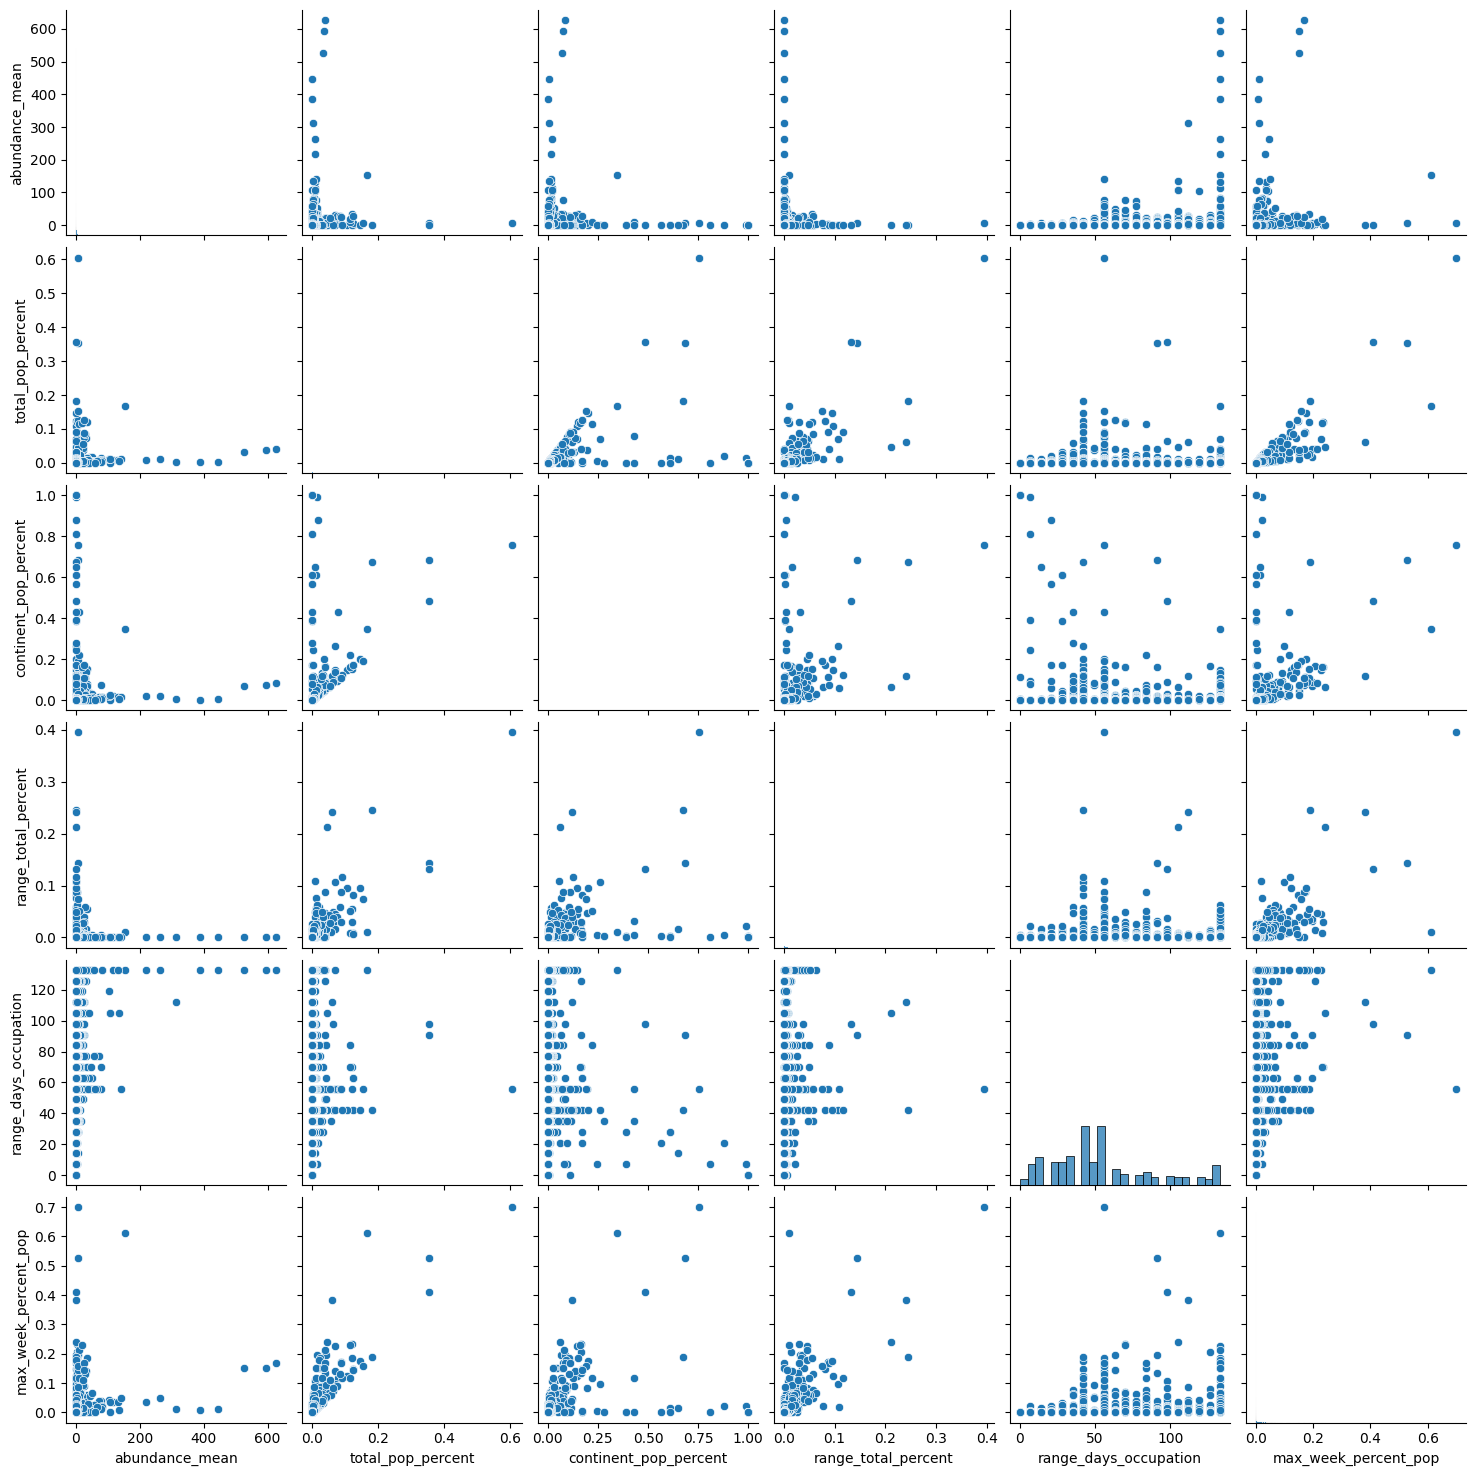

In [5]:
numeric_cols = [
    'abundance_mean',
    'total_pop_percent',
    'continent_pop_percent',
    'range_total_percent',
    'range_days_occupation',
    'max_week_percent_pop'
]

for col in numeric_cols:
    bird[col] = pd.to_numeric(bird[col], errors='coerce')

sns.pairplot(bird)

In [ ]:
!pip install bambi
import bambi as bmb
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt

In [42]:
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt

In [ ]:
bird_cleaned = bird.dropna(subset=['abundance_mean', 'range_total_percent', 'range_days_occupation', 'season', 'continent_code', 'total_pop_percent']).copy()

#define the model
model_crane_all1 = bmb.Model("abundance_mean ~ range_total_percent + range_days_occupation", data=bird_cleaned)
#fit the model
idata_bird_1 = model_crane_all1.fit(idata_kwargs={'log_likelihood': True})

In [ ]:
bird_cleaned = bird.dropna(subset=['abundance_mean', 'range_total_percent', 'range_days_occupation', 'season', 'continent_code', 'total_pop_percent']).copy()

#define the model
model_crane_all2 = bmb.Model("abundance_mean ~ range_total_percent + range_days_occupation + season + continent_code + total_pop_percent", data=bird_cleaned)
#fit the model
idata_bird_2 = model_crane_all2.fit(idata_kwargs={'log_likelihood': True})

In [ ]:
bird_cleaned = bird.dropna(subset=['abundance_mean', 'range_total_percent', 'range_days_occupation', 'season', 'continent_code', 'total_pop_percent']).copy()

#define the model
model_crane_all3 = bmb.Model("abundance_mean ~ range_total_percent + range_days_occupation + season + continent_code + total_pop_percent + continent_pop_percent", data=bird_cleaned)
#fit the model
idata_bird_3 = model_crane_all3.fit(idata_kwargs={'log_likelihood': True})

range occupied percent is giving me trouble!!

In [ ]:
##bird_cleaned = bird.dropna(subset=['abundance_mean', 'range_total_percent', 'range_days_occupation', 'season', 'continent_code', 'total_pop_percent']).copy()

#define the model
##model_crane_all = bmb.Model("abundance_mean ~ range_total_percent + range_days_occupation + season + continent_code + total_pop_percent + continent_pop_percent + range_occupied_percent", data=bird_cleaned)
#fit the model
##idata_bird_4 = model_crane_all.fit(idata_kwargs={'log_likelihood': True})

In [ ]:
#define the model
model_crane_all5 = bmb.Model("abundance_mean ~ range_total_percent + continent_code + total_pop_percent + continent_pop_percent", data=bird_cleaned)
#fit the model
idata_bird_5 = model_crane_all5.fit(idata_kwargs={'log_likelihood': True})

In [ ]:
#define the model
model_crane_6a = bmb.Model("abundance_mean ~ range_total_percent + range_days_occupation + season + continent_code + total_pop_percent + continent_pop_percent	+ range_days_occupation", data=bird_cleaned)
#fit the model
idata_bird_6a = model_crane_all6a.fit(idata_kwargs={'log_likelihood': True})

In [ ]:
#define the model
model_crane_all6 = bmb.Model("abundance_mean ~ continent_code + continent_pop_percent", data=bird_cleaned)
#fit the model
idata_bird_6 = model_crane_all6.fit(idata_kwargs={'log_likelihood': True})

In [ ]:
#define the model
model_crane_all7 = bmb.Model("abundance_mean ~ continent_code * continent_pop_percent", data=bird_cleaned)
#fit the model
idata_bird_7 = model_crane_all7.fit(idata_kwargs={'log_likelihood': True})

I made a model with "continent" interacting with "continent population percent" and it performed significantly better than without it. I wonder if adding this interaction with my current best model Range + Categorial + TPP + CPP will improve it.

In [ ]:
#define the model
model_crane_all8 = bmb.Model("abundance_mean ~ range_total_percent + range_days_occupation + season + continent_code + total_pop_percent + continent_pop_percent + continent_pop_percent:continent_code", data=bird_cleaned)
#fit the model
idata_bird_8 = model_crane_all8.fit(idata_kwargs={'log_likelihood': True})

I am now going to try interactions between other variables in an attempt to improve my best model. The interactions that make the most sense

In [ ]:
cmp_df = az.compare( {"range data only":idata_bird_1,"range+categorical+tpp+CPP":idata_bird_3, "range + categorical + tpp":idata_bird_2, "rtp + cc + tpp + cpp":idata_bird_5, "continent data only no int":idata_bird_6, "continent data only interaction":idata_bird_7, "(range + categorical + tpp + cpp) + int btwn CC & CPP":idata_bird_8} )
cmp_df

<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

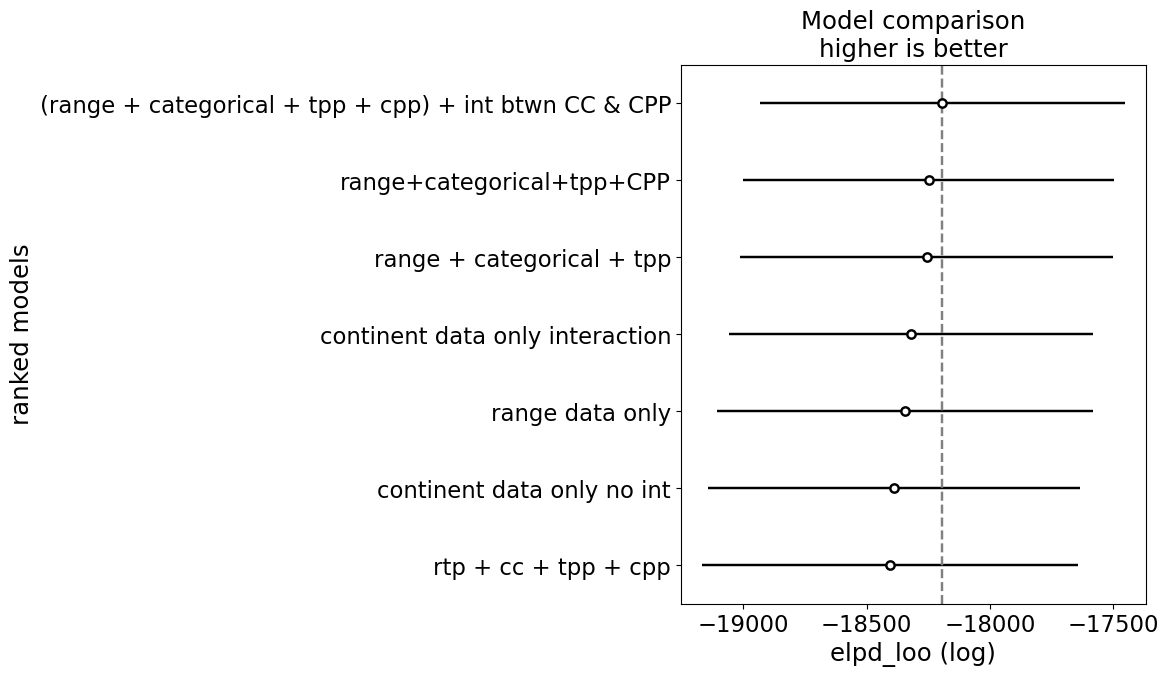

In [41]:
az.plot_compare(cmp_df)

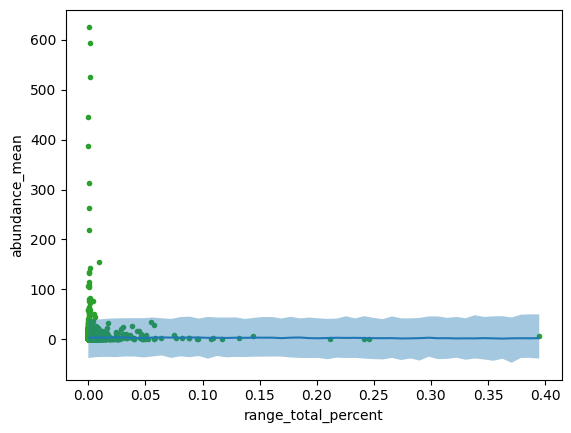

In [52]:
#note the 'pps=True' argument added in to get a full posterior predictive check
bmb.interpret.plot_predictions(model_crane_all1, idata_bird_1, "range_total_percent", pps=True)
plt.plot(bird_cleaned.range_total_percent, bird_cleaned.abundance_mean, "C2.", zorder=-3)

This visualization makes it pretty clear to me that this model is not very good. I'll try with another model, but I think the curve I'm trying to predict is just too steep ¯\\_(ツ)_/¯

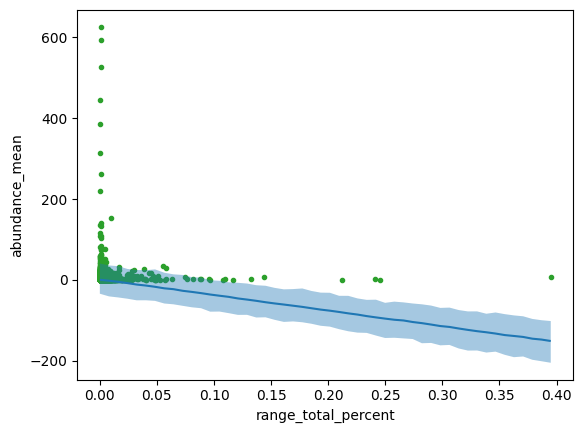

In [55]:
#note the 'pps=True' argument added in to get a full posterior predictive check
bmb.interpret.plot_predictions(model_crane_all8, idata_bird_8, "range_total_percent", pps=True)
plt.plot(bird_cleaned.range_total_percent, bird_cleaned.abundance_mean, "C2.", zorder=-3)

Despite having a better elpd_loo, I conclude this model is worse, because a negative abundance mean does not make sense in context. Abundance mean is the average number of birds you'd see in 2 hours, so negative birds is nonsensical.

In conclusion, my model "model_crane_all1" (AKA the model with only the range data) is the best because it predicts positive birds most of the time. Contextually, I think this just means my data is not conclusive, which makes sense because it is most definitly incomplete. I highly doubt all the common cranes in the wold have been accurately mapped by eBird, especially because it is based in the US and citizen scientist gathered data means areas with less eBird users will underreport their birds.

Also, my data was really steep, meaning the curve is kinda impossible (with my skill set) to accurately map out right now.